# Kaggle Icecore challenge

Outline:

- minor exploratory stuff (class numbers, na's with incidence angle, etc)

- Get baseline up with a vgg or inception arch on each image, and then for  final classification, pick whichever has a higher softmax output

- try image concatention like I did at aerospace, with no fine tuning

- try with fine tuning (somehow make it 3?)

- try ensembling different models (like vgg, inception, resnet)

- Then, try double vgg or inception like structure, concatenating on the    dense layers, with no fine tuing

- then with fine tuning

- try some including and excluding adding the incidence angle at the dense layers or end 

- Also, be careful with augmentation and the incidence angles, it may cause them to mess up, so it could be better to just leave incidence angles out if it allows us to do more aug



- **** Also, want to try to predict the missing incidence angles from the 
 rest of the ones we have, otherwise would have to throw out 133 images

- **** Also, need to examine the normalization, and potentially converting from decible values to something else, and then normalizing

In [1]:
# load data
import pandas as pd

training_path = "../Test_data/train.json"
testing_path = "../Test_data/test.json"

train_data = pd.read_json(training_path)
test_data = pd.read_json(testing_path)

total data points in testing:  8424
total data points in training:  1604
number of non missing inc_angles:  1471
number of missing inc_angles:  133
percent missing inc_angles:  0.09041468388851122


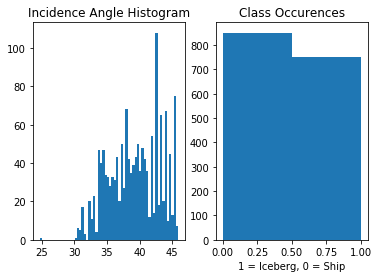

In [10]:
# exploratory stuff
import numpy as np
import matplotlib.pyplot as plt

# get list of angles/classes, len train data
is_icebergs = [x for x in train_data["is_iceberg"]]
inc_angles = [y for y in train_data["inc_angle"] if isinstance(y, float)]
inc_nas = [y for y in train_data["inc_angle"] if isinstance(y, str)]

print("total data points in testing: ", len(test_data))
print("total data points in training: ", len(train_data))
print("number of non missing inc_angles: ", len(inc_angles))
print("number of missing inc_angles: ", len(inc_nas))
print("percent missing inc_angles: ", float(len(inc_nas))/float(len(inc_angles)))

plt.subplot(1, 2, 1)
plt.hist(inc_angles, bins = 60)
plt.title('Incidence Angle Histogram')

plt.subplot(1, 2, 2)
plt.hist(is_icebergs, bins = 2)
plt.title('Class Occurences')
plt.xlabel('1 = Iceberg, 0 = Ship')

plt.show()

# Notes

- The classes seem to be pretty evenly balanced, maybe about 100 less icebergs, could fix that

- the incidence angles seem a little right tailed, with a lot of them coming from exactly the same angles, interesting

band_1
DescribeResult(nobs=56407500, minmax=(-45.680545806884766, 37.090522999999997), mean=-22.159242988927875, variance=28.424440324407545, skewness=0.8502589192712555, kurtosis=2.3675551655768574)
 
band_2
DescribeResult(nobs=56407500, minmax=(-49.083500000000001, 37.090522766113281), mean=-24.953674182125951, variance=20.669753971968337, skewness=1.30140098134072, kurtosis=4.262312862918784)


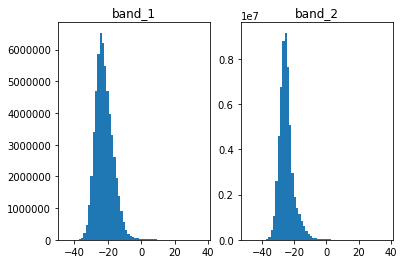

In [12]:
# need to get our data all sorted first, as well as normalize
# examining the possible values these scatterback radar's can make
# they are floats, with units in dB's

from scipy import stats

band1s = []
for i in train_data["band_1"]:
    for j in i:
        band1s.append(j)
        
for w in test_data["band_1"]:
    for z in w:
        band1s.append(z)
        
band2s = []
for r in train_data["band_2"]:
    for k in r:
        band2s.append(k)
        
for l in test_data["band_2"]:
    for s in l:
        band2s.append(s)

print("band_1")
print(stats.describe(band1s))
print(" ")
print("band_2")
print(stats.describe(band2s))
        
plt.subplot(1, 2, 1)
plt.hist(band1s, bins = 60)
plt.title('band_1')

plt.subplot(1, 2, 2)
plt.hist(band2s, bins = 60)
plt.title('band_2')

plt.show()

# Notes

- the decible values seem to be almost exactly normally distributed for band_1, band_2 may have a little right tailed

- band_1 min = -45, max = 37, 2 stds = 10
- band_2 min = -49, max = 37, 2 stds = 8.5


Normalizing decibal values can be weird, might want to look at converting them first, and them normalizing. For now, going to get a baseline without any normalization or conversion first

In [3]:
## baseline modeling (doing it without normalization, or regularization), or inc angle for now
from sklearn.model_selection import train_test_split
import numpy as np

from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import regularizers

#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_data["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_data["band_2"]])
X = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],
                          ((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

Y = train_data["is_iceberg"]
# Y = np_utils.to_categorical(y, 2)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=42)

print("size x_train", len(X_train))
print("size x_test", len(X_test))

# create the model
img_input = Input(shape=(75,75,3))
x = Convolution2D(64, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01), name='block1_conv1')(img_input)
x = Convolution2D(64, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01), name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
x = BatchNormalization()(x)

x = Convolution2D(128, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01), name='block2_conv1')(x)
x = Convolution2D(128, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01), name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
x = BatchNormalization()(x)

x = Convolution2D(256, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01), name='block3_conv1')(x)
x = Convolution2D(256, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01), name='block3_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
x = BatchNormalization()(x)

x = Flatten(name='flatten')(x)
x = Dense(512, kernel_regularizer=regularizers.l2(0.01),)(x)
x = Dense(512, kernel_regularizer=regularizers.l2(0.01),)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(img_input, x, name='vggBase')
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=25)

size x_train 1203
size x_test 401
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37

In [4]:
model.fit(X_train, y_train, batch_size = 32, epochs = 200,
         verbose= 1, validation_data = (X_test, y_test),
        shuffle=True, callbacks=callbacks)

Train on 1203 samples, validate on 401 samples
Epoch 1/200
1203/1203 [==============================] - 12s 10ms/step - loss: 22.7651 - acc: 0.6991 - val_loss: 22.8388 - val_acc: 0.5112
Epoch 2/200
1203/1203 [==============================] - 6s 5ms/step - loss: 22.3375 - acc: 0.8545 - val_loss: 22.6386 - val_acc: 0.5287
Epoch 3/200
1203/1203 [==============================] - 6s 5ms/step - loss: 22.1018 - acc: 0.9044 - val_loss: 22.4458 - val_acc: 0.5711
Epoch 4/200
1203/1203 [==============================] - 6s 5ms/step - loss: 21.8791 - acc: 0.9451 - val_loss: 22.3112 - val_acc: 0.5536
Epoch 5/200
1203/1203 [==============================] - 6s 5ms/step - loss: 21.6646 - acc: 0.9726 - val_loss: 22.1304 - val_acc: 0.5786
Epoch 6/200
1203/1203 [==============================] - 6s 5ms/step - loss: 21.4525 - acc: 0.9933 - val_loss: 21.8943 - val_acc: 0.6584
Epoch 7/200
1203/1203 [==============================] - 6s 5ms/step - loss: 21.2562 - acc: 0.9992 - val_loss: 21.6433 - val_acc:

1203/1203 [==============================] - 6s 5ms/step - loss: 11.0351 - acc: 1.0000 - val_loss: 11.3452 - val_acc: 0.8379
Epoch 61/200
1203/1203 [==============================] - 6s 5ms/step - loss: 10.8747 - acc: 1.0000 - val_loss: 11.1859 - val_acc: 0.8504
Epoch 62/200
1203/1203 [==============================] - 6s 5ms/step - loss: 10.7158 - acc: 1.0000 - val_loss: 11.0212 - val_acc: 0.8454
Epoch 63/200
1203/1203 [==============================] - 6s 5ms/step - loss: 10.5582 - acc: 1.0000 - val_loss: 10.8689 - val_acc: 0.8379
Epoch 64/200
1203/1203 [==============================] - 6s 5ms/step - loss: 10.4020 - acc: 1.0000 - val_loss: 10.7116 - val_acc: 0.8479
Epoch 65/200
1203/1203 [==============================] - 6s 5ms/step - loss: 10.2473 - acc: 1.0000 - val_loss: 10.5565 - val_acc: 0.8454
Epoch 66/200
1203/1203 [==============================] - 6s 5ms/step - loss: 10.0943 - acc: 1.0000 - val_loss: 10.4078 - val_acc: 0.8379
Epoch 67/200
1203/1203 [=======================

1203/1203 [==============================] - 6s 5ms/step - loss: 3.9363 - acc: 1.0000 - val_loss: 4.2174 - val_acc: 0.8753
Epoch 121/200
1203/1203 [==============================] - 6s 5ms/step - loss: 3.8580 - acc: 1.0000 - val_loss: 4.1396 - val_acc: 0.8728
Epoch 122/200
1203/1203 [==============================] - 6s 5ms/step - loss: 3.7814 - acc: 1.0000 - val_loss: 4.0584 - val_acc: 0.8753
Epoch 123/200
1203/1203 [==============================] - 6s 5ms/step - loss: 3.7055 - acc: 1.0000 - val_loss: 3.9936 - val_acc: 0.8678
Epoch 124/200
1203/1203 [==============================] - 6s 5ms/step - loss: 3.6309 - acc: 1.0000 - val_loss: 3.9087 - val_acc: 0.8803
Epoch 125/200
1203/1203 [==============================] - 6s 5ms/step - loss: 3.5576 - acc: 1.0000 - val_loss: 3.8278 - val_acc: 0.8728
Epoch 126/200
1203/1203 [==============================] - 6s 5ms/step - loss: 3.4854 - acc: 1.0000 - val_loss: 3.7649 - val_acc: 0.8728
Epoch 127/200
1203/1203 [==============================

Epoch 180/200
1203/1203 [==============================] - 6s 5ms/step - loss: 1.1655 - acc: 1.0000 - val_loss: 1.4371 - val_acc: 0.9027
Epoch 181/200
1203/1203 [==============================] - 7s 6ms/step - loss: 1.1449 - acc: 1.0000 - val_loss: 1.4133 - val_acc: 0.9077
Epoch 182/200
1203/1203 [==============================] - 6s 5ms/step - loss: 1.1244 - acc: 1.0000 - val_loss: 1.4000 - val_acc: 0.8953
Epoch 183/200
1203/1203 [==============================] - 6s 5ms/step - loss: 1.1058 - acc: 1.0000 - val_loss: 1.3898 - val_acc: 0.9052
Epoch 184/200
1203/1203 [==============================] - 6s 5ms/step - loss: 1.0853 - acc: 1.0000 - val_loss: 1.3549 - val_acc: 0.9052
Epoch 185/200
1203/1203 [==============================] - 6s 5ms/step - loss: 1.0660 - acc: 1.0000 - val_loss: 1.3495 - val_acc: 0.9127
Epoch 186/200
1203/1203 [==============================] - 6s 5ms/step - loss: 1.0468 - acc: 1.0000 - val_loss: 1.3175 - val_acc: 0.9102
Epoch 187/200
1203/1203 [================

In [7]:
from keras.models import load_model
import pandas as pd
inf_model = load_model(file_path)
score = inf_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_data["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_data["band_2"]])
X_sub = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=inf_model.predict(X_sub)

print("len of pred test", len(predicted_test))
print("len of id", len(test_data['id']))

submission = pd.DataFrame()
submission['id']=test_data['id']
submission['is_iceberg']=predicted_test
submission.to_csv('sub.csv', index=False)

401/401 [==============================] - 1s 2ms/step
Test loss: 1.10312891125
Test accuracy: 0.910224439349
len of pred test 8424
len of id 8424


In [ ]:
## Useful code snippets

# turn the flattened 'image' into 75 x 75
np.array(band).astype(np.float32).reshape(75, 75)

# concat them all together (should try more than just averging the two)
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis],
                X_band_2[:, :, :, np.newaxis], 
                          ((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]],
                         axis=-1)